# Member Churn Prediction

In [1]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")


In [2]:
import os

%matplotlib inline
import string
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    # plot_confusion_matrix,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor, export_graphviz
import altair as alt

# 1. Data splitting

In [3]:
df = pd.read_csv("data/bigml_59c28831336c6604c800002a.csv")
df

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,AZ,192,415,414-4276,no,yes,36,156.2,77,26.55,...,126,18.32,279.1,83,12.56,9.9,6,2.67,2,False
3329,WV,68,415,370-3271,no,no,0,231.1,57,39.29,...,55,13.04,191.3,123,8.61,9.6,4,2.59,3,False
3330,RI,28,510,328-8230,no,no,0,180.8,109,30.74,...,58,24.55,191.9,91,8.64,14.1,6,3.81,2,False
3331,CT,184,510,364-6381,yes,no,0,213.8,105,36.35,...,84,13.57,139.2,137,6.26,5.0,10,1.35,2,False


In [4]:
train_df, test_df = train_test_split(df, test_size=0.3, random_state=123)
train_df

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
1402,NE,70,415,421-8535,no,no,0,213.4,86,36.28,...,77,17.40,256.6,101,11.55,5.7,4,1.54,1,False
1855,WI,67,510,417-2265,no,no,0,109.1,134,18.55,...,76,12.10,91.2,86,4.10,10.9,5,2.94,2,False
633,NJ,122,415,327-9341,no,yes,34,146.4,104,24.89,...,103,7.62,220.0,91,9.90,15.6,4,4.21,2,False
1483,NV,107,510,419-9688,yes,no,0,234.1,91,39.80,...,105,13.86,282.5,100,12.71,10.0,3,2.70,1,False
2638,HI,105,510,364-8128,no,no,0,125.4,116,21.32,...,95,22.23,241.6,104,10.87,11.4,9,3.08,2,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2154,WY,126,408,339-9798,yes,no,0,197.6,126,33.59,...,112,20.95,285.3,104,12.84,12.5,8,3.38,2,False
3089,WV,70,510,348-3777,no,yes,30,143.4,72,24.38,...,92,14.45,127.9,68,5.76,9.4,4,2.54,3,False
1766,NJ,125,415,406-6400,no,no,0,182.3,64,30.99,...,121,11.88,171.6,96,7.72,11.6,7,3.13,2,False
1122,NE,159,415,362-5111,no,no,0,189.1,105,32.15,...,147,20.92,242.0,106,10.89,10.4,5,2.81,1,True


First thing to check is the distribution of target values:

In [5]:
train_df["churn"].value_counts(normalize=True)

churn
False    0.850407
True     0.149593
Name: proportion, dtype: float64

There is class imbalance and identifying "True" is important for us.

# 2. EDA

Checking the dimension of train df:

In [6]:
print("n=%d, d=%d" % train_df.shape)

n=2333, d=21


Checking if there is any duplicate phoe number (as it seems like this is the identifier):

In [7]:
len(train_df["phone number"].unique())

2333

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2333 entries, 1402 to 1346
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   2333 non-null   object 
 1   account length          2333 non-null   int64  
 2   area code               2333 non-null   int64  
 3   phone number            2333 non-null   object 
 4   international plan      2333 non-null   object 
 5   voice mail plan         2333 non-null   object 
 6   number vmail messages   2333 non-null   int64  
 7   total day minutes       2333 non-null   float64
 8   total day calls         2333 non-null   int64  
 9   total day charge        2333 non-null   float64
 10  total eve minutes       2333 non-null   float64
 11  total eve calls         2333 non-null   int64  
 12  total eve charge        2333 non-null   float64
 13  total night minutes     2333 non-null   float64
 14  total night calls       2333 non-null   in

In [9]:
train_df.describe()

,account length,area code,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls
count,2333.000000,2333.000000,2333.000000,2333.000000,2333.000000,2333.000000,2333.000000,2333.000000,2333.000000,2333.000000,2333.000000,2333.000000,2333.000000,2333.000000,2333.000000,2333.000000
mean,100.434634,436.324046,8.028290,179.655679,100.567081,30.542015,201.175782,99.885555,17.100210,201.211745,99.988856,9.054591,10.269567,4.503215,2.773365,1.551650
std,39.642470,41.854200,13.665229,54.546284,20.202414,9.272847,50.449386,19.788878,4.288194,50.888058,19.406455,2.290012,2.777601,2.507555,0.749929,1.328702
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,73.000000,408.000000,0.000000,143.400000,87.000000,24.380000,167.300000,87.000000,14.220000,166.900000,87.000000,7.510000,8.500000,3.000000,2.300000,1.000000
50%,100.000000,415.000000,0.000000,179.200000,101.000000,30.460000,202.400000,100.000000,17.200000,201.600000,100.000000,9.070000,10.400000,4.000000,2.810000,1.000000
75%,127.000000,415.000000,19.000000,216.300000,114.000000,36.770000,236.000000,113.000000,20.060000,236.600000,113.000000,10.650000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,354.200000,168.000000,30.110000,377.500000,164.000000,16.990000,20.000000,20.000000,5.400000,9.000000


In [10]:
possibly_most_relevant = [
    "total day minutes",
    "total day charge",
    "total eve minutes",
    "total eve charge",
    "total intl minutes",
    "total intl charge",
    "customer service calls",
    "churn"
]
cor = train_df[possibly_most_relevant].corr()
cor

,total day minutes,total day charge,total eve minutes,total eve charge,total intl minutes,total intl charge,customer service calls,churn
total day minutes,1.000000,1.000000,0.023442,0.023441,-0.005937,-0.005812,-0.021350,0.215746
total day charge,1.000000,1.000000,0.023457,0.023456,-0.005940,-0.005814,-0.021356,0.215749
total eve minutes,0.023442,0.023457,1.000000,1.000000,-0.007664,-0.007760,-0.026125,0.087715
total eve charge,0.023441,0.023456,1.000000,1.000000,-0.007682,-0.007778,-0.026142,0.087705
total intl minutes,-0.005937,-0.005940,-0.007664,-0.007682,1.000000,0.999993,0.009233,0.064230
total intl charge,-0.005812,-0.005814,-0.007760,-0.007778,0.999993,1.000000,0.009153,0.064267
customer service calls,-0.021350,-0.021356,-0.026125,-0.026142,0.009233,0.009153,1.000000,0.216641
churn,0.215746,0.215749,0.087715,0.087705,0.064230,0.064267,0.216641,1.000000


- We have colinear features like total day minutes and total day charge (correlation=1)
- A quick look at correlation shows that total day minutes and charge, and customer service calls have strong impact on churn. 
- I will drop total day charge, total eve charge, total night charge, and total intl charge to make the model simpler
- Visualizing:

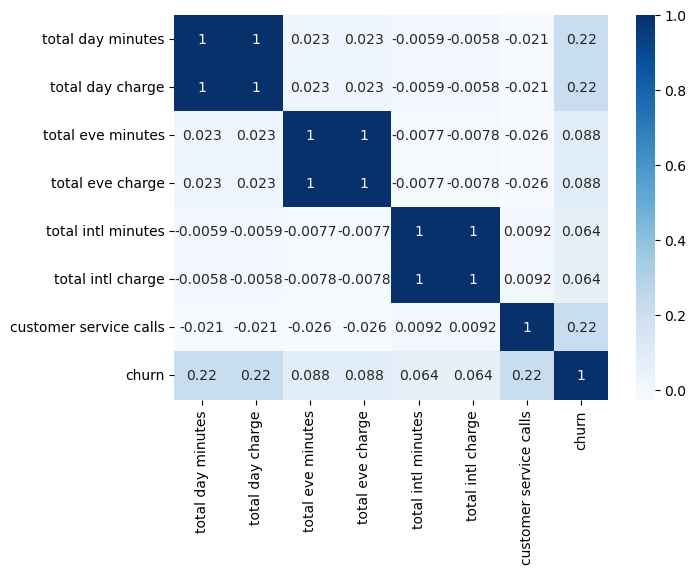

In [11]:
import seaborn as sns

plt.figure(figsize=(7, 5))
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues)
plt.show()

array([[<Axes: title={'center': 'account length'}>,
        <Axes: title={'center': 'area code'}>,
        <Axes: title={'center': 'number vmail messages'}>,
        <Axes: title={'center': 'total day minutes'}>],
       [<Axes: title={'center': 'total day calls'}>,
        <Axes: title={'center': 'total day charge'}>,
        <Axes: title={'center': 'total eve minutes'}>,
        <Axes: title={'center': 'total eve calls'}>],
       [<Axes: title={'center': 'total eve charge'}>,
        <Axes: title={'center': 'total night minutes'}>,
        <Axes: title={'center': 'total night calls'}>,
        <Axes: title={'center': 'total night charge'}>],
       [<Axes: title={'center': 'total intl minutes'}>,
        <Axes: title={'center': 'total intl calls'}>,
        <Axes: title={'center': 'total intl charge'}>,
        <Axes: title={'center': 'customer service calls'}>]], dtype=object)

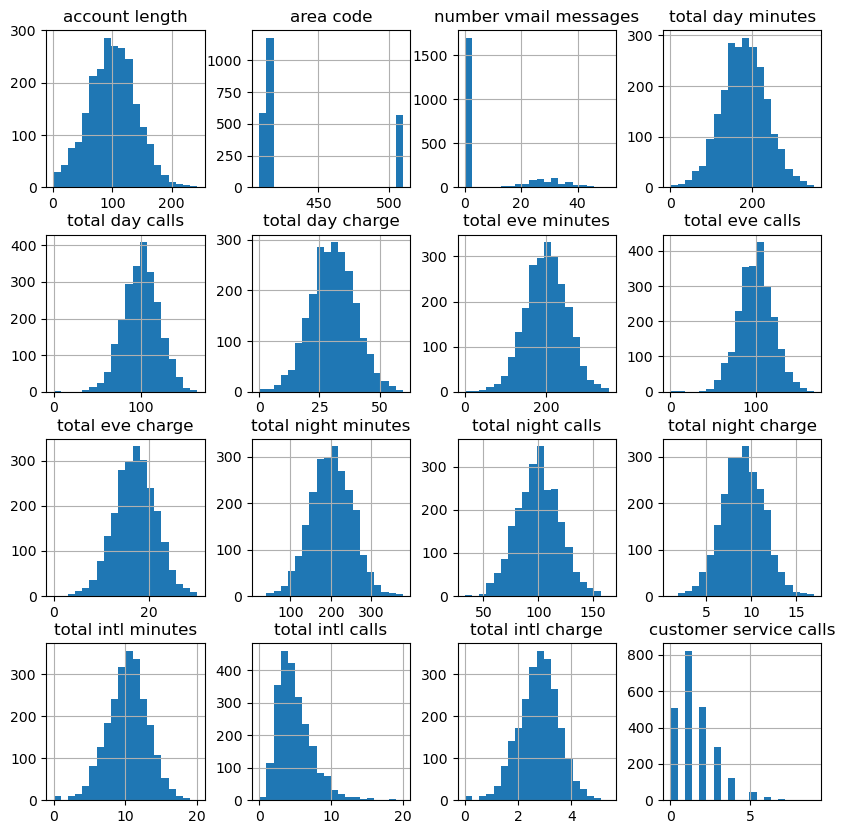

In [12]:
train_df.hist(figsize=(10, 10), bins=20)

In [13]:
alt.Chart(df).mark_bar().encode(
    alt.X(alt.repeat(), type='nominal', axis=alt.Axis(labels=False)),
    alt.Y('count()', stack=False),
    color='churn',
    opacity=alt.value(0.7)
).properties( 
    width=200, 
    height=200 
).repeat( 
    list(set(train_df.columns) - set("phone number")),
    columns=7
)

alt.RepeatChart(...)

In [14]:
int_counts = train_df['international plan'].value_counts()
print(int_counts)

international plan
no     2106
yes     227
Name: count, dtype: int64


Looks like most people who had internation plan ended up staying as a customer.

# 3. Preprocessing

In [15]:
X_train = train_df.drop(columns=["churn"])
X_test = test_df.drop(columns=["churn"])

y_train = train_df["churn"]
y_test = test_df["churn"]

In [16]:
categorical_features = ["area code", "state"]
binary_features = ["international plan", "voice mail plan"]
drop_features = ["phone number", "total day charge", "total eve charge", "total night charge", "total intl charge"] # drop irrelevant features
numeric_features = list(
    set(train_df.columns)
    - set(["churn"])
    - set(binary_features)
    - set(categorical_features)
    - set(drop_features)
)

In [17]:
preprocessor = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(drop="if_binary"), binary_features),
    (OneHotEncoder(handle_unknown="ignore", sparse=False), categorical_features),
    ("drop", drop_features),
)

In [18]:
preprocessor.fit(X_train)
preprocessor.named_transformers_

{'standardscaler': StandardScaler(),
 'onehotencoder-1': OneHotEncoder(drop='if_binary'),
 'onehotencoder-2': OneHotEncoder(handle_unknown='ignore', sparse=False, sparse_output=False),
 'drop': 'drop'}

In [19]:
new_columns = (
    numeric_features
    + binary_features
    + list(
        preprocessor.named_transformers_["onehotencoder-2"].get_feature_names_out(
            categorical_features
        )
    )
)

In [20]:
X_train_enc = pd.DataFrame(
    preprocessor.transform(X_train), index=X_train.index, columns=new_columns
)

Viewing preprocessed df:

In [21]:
pd.set_option('display.max_columns', None)
X_train_enc.head()

,total eve minutes,total night minutes,number vmail messages,total night calls,customer service calls,total eve calls,total intl calls,total intl minutes,total day calls,account length,total day minutes,international plan,voice mail plan,area code_408,area code_415,area code_510,state_AK,state_AL,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,state_FL,state_GA,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_RI,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
1402,0.069871,1.088667,-0.587624,0.052115,-0.415269,-1.156734,-0.200722,-1.645501,-0.721211,-0.767893,0.618769,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1855,-1.167277,-2.162302,-0.587624,-0.720990,0.337507,-1.207278,0.198158,0.227019,1.655252,-0.843585,-1.293778,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
633,-2.210130,0.369287,1.900976,-0.463288,0.337507,0.157417,-0.200722,1.919489,0.169963,0.544113,-0.609809,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1483,-0.754894,1.597736,-0.587624,0.000574,-0.415269,0.258506,-0.599603,-0.097071,-0.473663,0.165650,0.998345,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2638,1.195994,0.793839,-0.587624,0.206736,0.337507,-0.246937,1.793679,0.407069,0.764078,0.115188,-0.994886,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 4. Modeling

In [22]:
results = {}

In [23]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

Testing with DummyClassifier first:

In [24]:
scoring = ["accuracy", "f1", "recall", "precision", "roc_auc", "average_precision"]
dc = DummyClassifier()
results["dummy"] = mean_std_cross_val_scores(dc, X_train, y_train, scoring=scoring)
pd.DataFrame(results)

,dummy
fit_time,0.001 (+/- 0.000)
score_time,0.015 (+/- 0.002)
test_accuracy,0.850 (+/- 0.001)
test_f1,0.000 (+/- 0.000)
test_recall,0.000 (+/- 0.000)
test_precision,0.000 (+/- 0.000)
test_roc_auc,0.500 (+/- 0.000)
test_average_precision,0.150 (+/- 0.001)


Logistic Regression and SVC:

In [25]:
pipe_lr = make_pipeline(
    preprocessor, LogisticRegression(max_iter=1000, random_state=123)
)

In [26]:
pipe_svc = make_pipeline(preprocessor, SVC(random_state=123))

Examining confusion matrix given by Logistic Regression and SVC:

In [27]:
from sklearn.model_selection import cross_val_predict

confusion_matrix(y_train, cross_val_predict(pipe_lr, X_train, y_train))

array([[1924,   60],
       [ 276,   73]])

In [28]:
confusion_matrix(y_train, cross_val_predict(pipe_svc, X_train, y_train))

array([[1968,   16],
       [ 229,  120]])

The number of false negatives is high for both classifiers, which is very alarming. For example, Logistic Regression predicted 276 as False Negative, which is 80% of all the True Positive cases. SVC models follow the same performance. This is most likely due to class imbalance.

In [29]:
results["logistic regression"] = mean_std_cross_val_scores(
    pipe_lr, X_train, y_train, scoring=scoring
)
results["svc"] = mean_std_cross_val_scores(pipe_svc, X_train, y_train, scoring=scoring)

In [30]:
pd.DataFrame(results)

,dummy,logistic regression,svc
fit_time,0.001 (+/- 0.000),0.033 (+/- 0.007),0.102 (+/- 0.012)
score_time,0.015 (+/- 0.002),0.025 (+/- 0.001),0.138 (+/- 0.008)
test_accuracy,0.850 (+/- 0.001),0.856 (+/- 0.013),0.895 (+/- 0.007)
test_f1,0.000 (+/- 0.000),0.303 (+/- 0.063),0.492 (+/- 0.065)
test_recall,0.000 (+/- 0.000),0.209 (+/- 0.046),0.344 (+/- 0.064)
test_precision,0.000 (+/- 0.000),0.549 (+/- 0.105),0.889 (+/- 0.057)
test_roc_auc,0.500 (+/- 0.000),0.797 (+/- 0.020),0.893 (+/- 0.021)
test_average_precision,0.150 (+/- 0.001),0.439 (+/- 0.051),0.742 (+/- 0.026)


Recall score and F1 scores important as we are trying to predict the churn cases. Both models are not doing so well and class imbalance issue has to be addressed, with class_weight = 'balanced.'

In [31]:
pipe_lr_balanced = make_pipeline(
    preprocessor,
    LogisticRegression(max_iter=1000, class_weight="balanced", random_state=123),
)

In [32]:
pipe_svc_balanced = make_pipeline(
    preprocessor, SVC(class_weight="balanced", random_state=123)

)

In [33]:
confusion_matrix(y_train, cross_val_predict(pipe_lr_balanced, X_train, y_train))

array([[1531,  453],
       [ 105,  244]])

In [34]:
confusion_matrix(y_train, cross_val_predict(pipe_svc_balanced, X_train, y_train))


array([[1807,  177],
       [  98,  251]])

In [35]:
results["logistic regression (balanced)"] = mean_std_cross_val_scores(
    pipe_lr_balanced, X_train, y_train, scoring=scoring
)
results["svc (balanced)"] = mean_std_cross_val_scores(
    pipe_svc_balanced, X_train, y_train, scoring=scoring
)

In [36]:
pd.DataFrame(results)

,dummy,logistic regression,svc,logistic regression (balanced),svc (balanced)
fit_time,0.001 (+/- 0.000),0.033 (+/- 0.007),0.102 (+/- 0.012),0.038 (+/- 0.007),0.170 (+/- 0.024)
score_time,0.015 (+/- 0.002),0.025 (+/- 0.001),0.138 (+/- 0.008),0.024 (+/- 0.001),0.206 (+/- 0.013)
test_accuracy,0.850 (+/- 0.001),0.856 (+/- 0.013),0.895 (+/- 0.007),0.761 (+/- 0.020),0.882 (+/- 0.012)
test_f1,0.000 (+/- 0.000),0.303 (+/- 0.063),0.492 (+/- 0.065),0.467 (+/- 0.023),0.646 (+/- 0.030)
test_recall,0.000 (+/- 0.000),0.209 (+/- 0.046),0.344 (+/- 0.064),0.699 (+/- 0.034),0.719 (+/- 0.038)
test_precision,0.000 (+/- 0.000),0.549 (+/- 0.105),0.889 (+/- 0.057),0.351 (+/- 0.024),0.588 (+/- 0.035)
test_roc_auc,0.500 (+/- 0.000),0.797 (+/- 0.020),0.893 (+/- 0.021),0.799 (+/- 0.024),0.889 (+/- 0.016)
test_average_precision,0.150 (+/- 0.001),0.439 (+/- 0.051),0.742 (+/- 0.026),0.425 (+/- 0.058),0.696 (+/- 0.027)


Recall and F1 scores improved greatly but still more room for improvements. As SVC is performing better than LR model, hyperparameter optimization can be carried out with SVC.

In [37]:
pipe_svc = make_pipeline(preprocessor, SVC(random_state=123))

In [38]:
from scipy.stats import lognorm, loguniform

param_dist = {
    "svc__C": loguniform(1e-3, 1e3),
    "svc__gamma": loguniform(1e-3, 1e3),
    "svc__class_weight": [None, "balanced"],
}

Performing randomized search instead of exhausitive grid search for more efficiency:

In [39]:
search = RandomizedSearchCV(
    pipe_svc,
    param_dist,
    verbose=1,
    n_jobs=-1,
    n_iter=50,
    return_train_score=True,
    scoring="f1",
    random_state=123,
)

In [40]:
search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/opt/miniconda3/envs/573/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/miniconda3/envs/573/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/miniconda3/envs/573/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/miniconda3/envs/573/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in 

RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('standardscaler',
                                                                               StandardScaler(),
                                                                               ['total '
                                                                                'eve '
                                                                                'minutes',
                                                                                'total '
                                                                                'night '
                                                                                'minutes',
                                                                                'number '
                                                                                'vmail '
                                                                                'messages',
                                                                                'total '
                                                                                'night '
                                                                                'calls',
                                                                                'customer '
                                                                                'service '
                                                                                'calls',
                                                                                'total '
                                                                                'eve '
                                                                                'calls',
                                                                                'total '
                                                                                'intl '
                                                                                'calls',
                                                                                'total '
                                                                                'intl '
                                                                                'minutes',
                                                                                'total '
                                                                                'day '
                                                                                'calls',
                                                                                'account '
                                                                                'l...
                                             ('svc', SVC(random_state=123))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'svc__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x16d13c8e0>,
                                        'svc__class_weight': [None, 'balanced'],
                                        'svc__gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x16d136070>},
                   random_state=123, return_train_score=True, scoring='f1',
                   verbose=1)

In [41]:
search_df = pd.DataFrame(search.cv_results_)[
    [
        "rank_test_score",
        "mean_test_score",
        "mean_train_score",
        "param_svc__C",
        "param_svc__gamma",
        "param_svc__class_weight",
    ]
]
search_df = search_df.sort_values(by="mean_test_score", ascending=False)
search_df.T

,45,16,42,29,38,39,4,43,21,3,34,18,14,22,35,31,44,47,0,6,37,36,40,41,46,33,32,48,30,25,28,27,2,5,7,8,9,10,11,12,13,15,17,19,20,23,24,1,26,49
rank_test_score,1,2,3,4,5,6,7,8,9,10,11,12,13,13,13,13,13,18,19,20,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21
mean_test_score,0.62507,0.600267,0.592407,0.588091,0.585027,0.573218,0.571002,0.519697,0.509985,0.470872,0.464709,0.260252,0.208663,0.208663,0.208663,0.208663,0.208663,0.208013,0.14428,0.055255,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean_train_score,0.767009,0.951091,0.964219,0.67012,0.982899,1.0,0.619612,1.0,0.545923,1.0,1.0,0.260253,0.208088,0.208088,0.208112,0.208088,0.208088,0.20825,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.008541,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
param_svc__C,0.322073,5.542653,9.319359,326.844217,14.132233,37.722977,0.114569,80.828599,0.049684,3.007224,112.207008,0.031822,0.074742,0.066792,0.024424,0.04839,0.079566,0.071646,15.094374,26.789983,6.73186,16.97278,1.198861,0.027637,2.061676,0.020429,0.081771,270.426629,3.686305,0.041984,0.003752,0.012079,0.345652,0.029414,0.00318,6.403328,27.655298,0.086647,0.025532,0.00357,0.011052,14.468365,0.963502,0.024947,0.005294,164.518878,10.372482,13.973626,0.003156,0.494675
param_svc__gamma,0.107653,0.065358,0.05783,0.00125,0.056954,0.11501,0.088086,0.203717,0.113916,0.225271,0.227859,0.939617,31.788661,13.665705,0.244971,14.899688,162.716999,851.280168,0.372242,0.43807,3.622943,0.001059,2.052402,0.085484,3.046436,355.463439,287.485792,1.764267,1.104653,113.254281,0.009133,2.721083,0.29211,0.244492,1.552264,0.896414,21.610275,0.174908,6.107405,0.001472,0.358907,1.025699,157.708444,4.757372,61.146338,1.154872,105.272947,20.740242,222.154224,257.910032
param_svc__class_weight,balanced,None,None,balanced,None,None,balanced,balanced,balanced,balanced,None,balanced,balanced,balanced,balanced,balanced,balanced,balanced,None,balanced,balanced,None,None,None,None,None,None,balanced,None,None,None,None,None,None,None,None,None,None,None,None,None,None,balanced,None,None,balanced,balanced,balanced,None,None


Best parameters are:
- class weight = 'balanced'
- gamma = 0.1076
- C = 0.322073

# 5. Results

Score on the test set with optimized model, along with the confusion matrix:

In [42]:
search.score(X_test, y_test)

0.6407766990291263

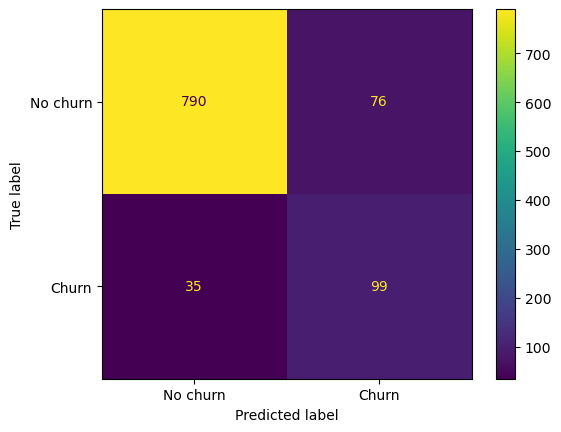

In [43]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

disp = ConfusionMatrixDisplay.from_estimator(
    search, X_test, y_test, display_labels=["No churn", "Churn"]
)

Utilizing more convenient classification report tool from Sklearn:

In [44]:
print(
    classification_report(
        y_test, search.predict(X_test), target_names=["No churn", "Churn"]
    )
)

              precision    recall  f1-score   support

    No churn       0.96      0.91      0.93       866
       Churn       0.57      0.74      0.64       134

    accuracy                           0.89      1000
   macro avg       0.76      0.83      0.79      1000
weighted avg       0.91      0.89      0.90      1000



If we want to increase the threshold of 0.5 and have a better recall score and trade off precision score, then we can check the thresholds first with PR Curve:

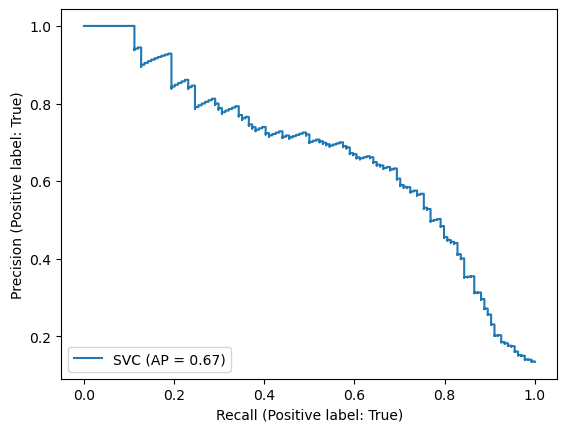

In [45]:
from sklearn.metrics import PrecisionRecallDisplay

PrecisionRecallDisplay.from_estimator(search, X_test, y_test, name="SVC")

- AP score of 0.67 is considered very good

Similar to PR Curve, ROC Curve looks at False Positive Rate and True Positive Rate:
- FPR = FP/(FP+TN)
- TPR = TP/(TP+FN)

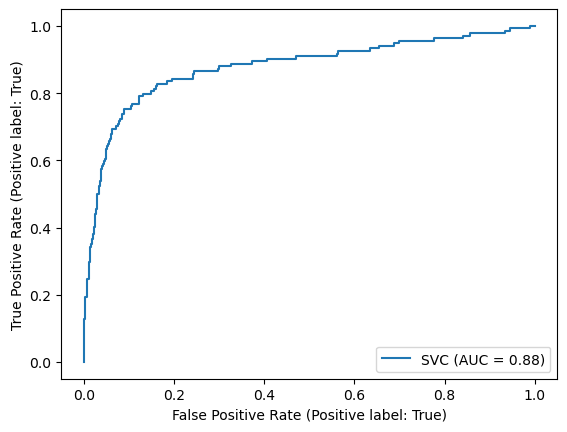

In [46]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(search, X_test, y_test, name="SVC")

- AUC score of 0.88 is considered quite good and we are able to predict the churn cases with good discrimation with our model